# Libraries and Device Checker for GPU or CPU Usage

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from scipy.special import expit

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Check if GPU is available and will be used in this notebook

cpu


# Sub- and Super-Solution-Based PINNs for Nonlinear BVPs

## 1 Introduction  
Physics-Informed Neural Networks (PINNs) offer a flexible framework for solving nonlinear boundary value problems (BVPs). However, standard PINNs can struggle with convergence and accuracy in stiff or nonlinear problems. 

Here, we demonstrate a PINN approach for a nonlinear steady-state reaction-diffusion equation, constrained by analytically derived sub- and super-solutions. This bounding guarantees physically admissible solutions and improves training stability. We also explore a custom Cosine activation functions to capture higher-order derivatives accurately.  

The network is benchmarked against high-precision numerical solutions, highlighting the benefits of this bounded structure.


## 1.1 Problem Setup

We consider the nonlinear reaction-diffusion BVP:

$$
\begin{cases}
-u''(x) = \lambda\, u(x)\,(1 - u(x)), & x \in (0, 1) \\
-u'(0) + \sqrt{\lambda}\,\gamma\, u(0) = 0 \\
u'(1) + \sqrt{\lambda}\,\gamma\, u(1) = 0
\end{cases}
$$

This models a steady-state balance between diffusion and logistic reaction kinetics. As the boundary parameter $\sqrt{\lambda}\,\gamma$ increases, the system exhibits bifurcation behavior, which poses challenges for standard numerical and neural solvers.


## 1.2 Motivation

Standard PINNs may fail near boundaries or for stiff nonlinear BVPs due to:

- Vanishing gradients
- Instability near boundary layers
- Nonphysical predictions

### Our approach:  
1. Solve a linearized eigenvalue problem to construct valid sub- and super-solutions.
2. Constrain the neural network output within these bounds.
3. Use smooth periodic activations to improve accuracy of higher-order derivatives.

These modifications stabilize training and ensure physically admissible predictions.


## 1.3 Key Contributions

- **Bound construction via eigenfunctions:**  
  Analytically compute sub- and super-solutions that bound the network output and guarantee physically admissible predictions.  

- **Periodic activation functions:**  
  Use smooth, periodic activations to better capture higher-order derivatives required by the PDE residual.  

- **Sigmoid output scaling:**  
  Enforce that network predictions remain within the analytically derived bounds throughout training.  

- **Convergence through analytical bounding:**  
  Standard PINNs failed to converge for this nonlinear BVP due to stiffness and bifurcation behavior.  
  By constraining the network output between sub- and super-solutions, we achieved stable convergence and successfully solved a problem that standard PINNs could not.  

- **Benchmarking and validation:**  
  Comparison with high-precision quadrature-based solutions shows excellent agreement across parameter regimes.  

This framework demonstrates that embedding classical analytical structure into neural architectures significantly enhances the stability and reliability of PINNs, and is extensible to more complex PDEs in chemical transport, biological diffusion, and materials physics.


# 2 Mathematical Framework

## 2.1 Linearization and Principal Eigenvalue

We consider the nonlinear boundary value problem:

$$
\begin{cases}
-u''(x)  = \lambda r u  (1 - u ), & x \in (0, 1) \\
-u'(0) + \sqrt{\lambda} \gamma u(0) = 0 \\
u'(1) + \sqrt{\lambda} \gamma u(1) = 0
\end{cases}
$$

where $\lambda > 0$, $\gamma > 0$, and $r > 0$ are fixed parameters. This models steady-state reaction-diffusion dynamics with Robin boundary conditions.

To study the local behavior near the trivial steady state $u  \equiv 0$, we linearize the problem:

$$
\begin{cases}
-v''(x)  = \lambda r v , & x \in (0, 1), \\
-v'(0) + \sqrt{\lambda} \gamma v(0) = 0, \\
v'(1) + \sqrt{\lambda} \gamma v(1) = 0.
\end{cases}
$$

This linear BVP admits nontrivial solutions only for certain values of $\lambda$. The principal eigenvalue $\lambda_1$ is given explicitly by:

$$
\lambda_1 = \frac{4}{r} \left( \frac{\pi}{2} - \tan^{-1}\left(\frac{\sqrt{r}}{\gamma}\right) \right)^2.
$$

The corresponding normalized eigenfunction $\phi $, which satisfies the same boundary conditions, will be used to construct the Super and Sub Solutions.


## 2.2 Parameter Identification via the Quadrature Method

### Introduction

Before constructing the PINN, we need physically admissible parameters and reference solutions for validation.  
We aim to find consistent triplets $(q, \rho, \lambda)$:

- $q = u_{\min}$, $\rho = u_{\max}$: lower and upper turning points of the steady-state profile  
- $\lambda$: ensures the solution satisfies Robin boundary conditions and symmetry at $x = 0.5$


### 2.2.1 Potential function and turning point relation

The nonlinear potential is:

$$
F(u) = \frac{1}{2} u^2 - \frac{1}{3} u^3
$$

For a given $\rho$, $q$ satisfies the energy balance:

$$
F(\rho) = \frac{1}{2} \Big( 2 F(q) + \gamma^2 q^2 \Big)
$$

This is solved numerically using Brent’s method.

In [3]:
# Define F(u)
def F(u):
    return 0.5 * u**2 - (1/3) * u**3

# Calculate rho from q using the given relationship
def compute_q(rho, gamma):
    def equation_to_solve(q):
        if q <= 0 or q >= rho:
            return 1e6  # prevent invalid region
        return 0.5 * (2 * F(q) + gamma**2 * q**2) - F(rho)

    result = root_scalar(equation_to_solve, bracket=[1e-4, rho - 1e-4], method='brentq')
    return result.root if result.converged else np.nan

# Given q and rho, find lambda such that the integral equals 0.5
def find_lambda_for_q_rho(q, rho):
    def objective(lambd):
        if lambd <= 0:
            return 1e6
        try:
            integrand = lambda u: 1.0 / np.sqrt(2 * lambd * (F(rho) - F(u)))
            val, _ = quad(integrand, q, rho - 1e-8, limit=200)
            return val - 0.5
        except Exception:
            return 1e6

    result = root_scalar(objective, bracket=[1e-3, 1000], method='brentq')
    return result.root if result.converged else None

#### 2.2.2 Computing $\lambda$ from the quadrature integral
The nonlinear boundary value problem can be reduced to a first-order ODE via
$$
u'(x) = \sqrt{2\lambda\,(F(\rho) - F(u))},
$$
with symmetry at $x = 0.5$ implying $u'(0.5) = 0$.  
Integrating this equation from $u = q$ to $u = \rho$ yields
$$
\int_q^{\rho} \frac{du}{\sqrt{2\lambda\,(F(\rho) - F(u))}} = \frac{1}{2},
$$
which defines $\lambda$ implicitly as a function of $(q, \rho)$.  
For each $(q, \rho)$ pair, $\lambda$ is obtained numerically so that the integral equals $\tfrac{1}{2}$.

In [4]:
# Given q and rho, find lambda such that the integral equals 0.5
def find_lambda_for_q_rho(q, rho):
    def objective(lambd):
        if lambd <= 0:
            return 1e6
        try:
            integrand = lambda u: 1.0 / np.sqrt(2 * lambd * (F(rho) - F(u)))
            val, _ = quad(integrand, q, rho - 1e-8, limit=200)
            return val - 0.5
        except Exception:
            return 1e6

    result = root_scalar(objective, bracket=[1e-3, 1000], method='brentq')
    return result.root if result.converged else None

### 2.2.3 Printing Parameter Values and Visualization

Using the previous functions, $q$ values will be found with given $\rho$ values.

The resulting $q$ and $\rho$ pairs are then used to find valid $\lambda$ values to train the Network on.

The final plot shows the bifurcation curve of this problem as $\lambda -> \infty$

C:\Users\skyle\AppData\Local\Temp\ipykernel_30760\2340505113.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(integrand, q, rho - 1e-8, limit=200)
C:\Users\skyle\AppData\Local\Temp\ipykernel_30760\2340505113.py:8: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, q, rho - 1e-8, limit=200)


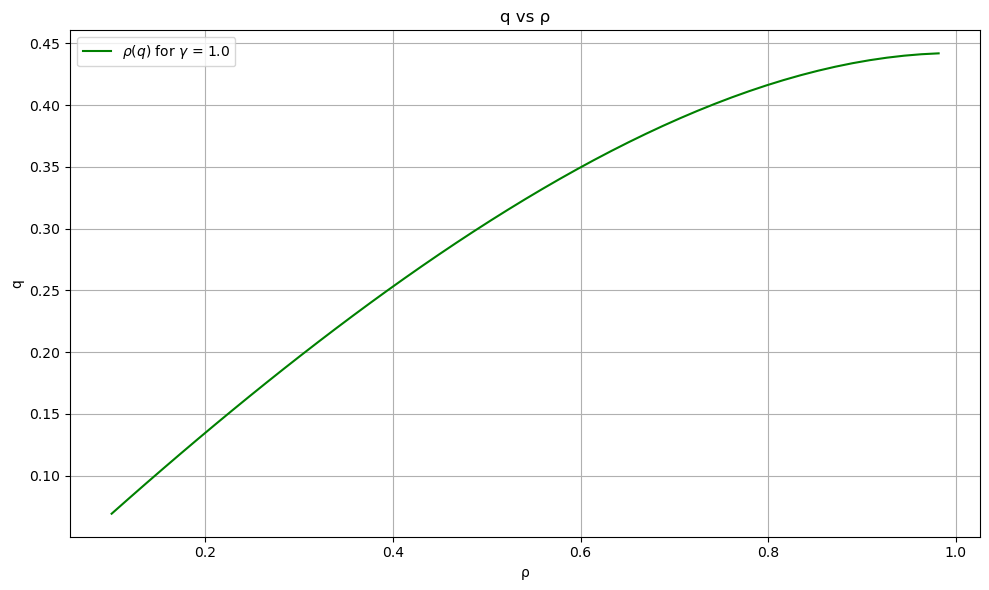

       q          rho       lambda
------------------------------------
0.069114     0.100000     2.883499
0.129504     0.191837     3.362515
0.186518     0.283673     3.978274
0.239673     0.375510     4.776953
0.288406     0.467347     5.848052
0.332062     0.559184     7.340323
0.369875     0.651020     9.532302
0.400947     0.742857    13.018866
0.424212     0.834694    19.379978
0.438388     0.926531    35.263987


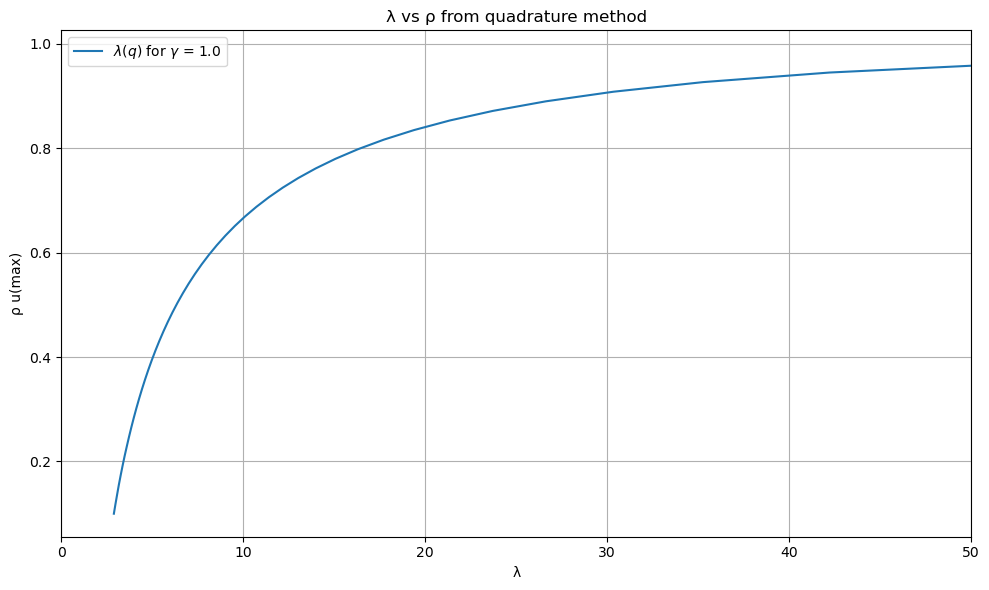

In [5]:
# Set gamma value
gamma = 1.0

# Choose a range of rho values and compute q, lambda
rho_values = np.linspace(0.1, 1.0, 50)
q_values = []
lambda_values = []

for rho in rho_values:
    try:
        q = compute_q(rho, gamma)
        lambd = find_lambda_for_q_rho(q, rho)
        q_values.append(q)
        lambda_values.append(lambd)
    except Exception:
        q_values.append(np.nan)
        lambda_values.append(np.nan)
        
# rho vs q plot
plt.figure(figsize=(10, 6))
plt.plot(rho_values, q_values, label=fr"$\rho(q)$ for $\gamma$ = {gamma}", color='green')
plt.ylabel("q")
plt.xlabel("ρ")
plt.title("q vs ρ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print some lambda values for q rho pairs
print(f"{'q':>8} {'rho':>12} {'lambda':>12}")
print("-" * 36)
for i in range(0, len(rho_values), max(1, len(rho_values)//10)):
    q = q_values[i]
    rho = rho_values[i]
    lambd = lambda_values[i]
    if not (np.isnan(rho) or np.isnan(lambd)):
        print(f"{q:8.6f} {rho:12.6f} {lambd:12.6f}")

# Plot lambda(ρ)
# Also known as the bifurcation curve
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, rho_values, label=r'$\lambda(q)$ for $\gamma$ = {}'.format(gamma))
plt.ylabel("ρ u(max)")
plt.xlabel("λ")
plt.xlim(0,50)
plt.grid(True)
plt.legend()
plt.title("λ vs ρ from quadrature method")
plt.tight_layout()
plt.show()


### 2.2.4 Solving ODE using Quadrature method

With proper triplets of $q$, $\rho$, and $\lambda$ found we are able to solve the ODE to construct $u(x)$ solution curves to compare our network to.

$\lambda$ values around 3, 5, 9, 19, and 35 were selected to give a diverse pool to train and evaluate the network on.

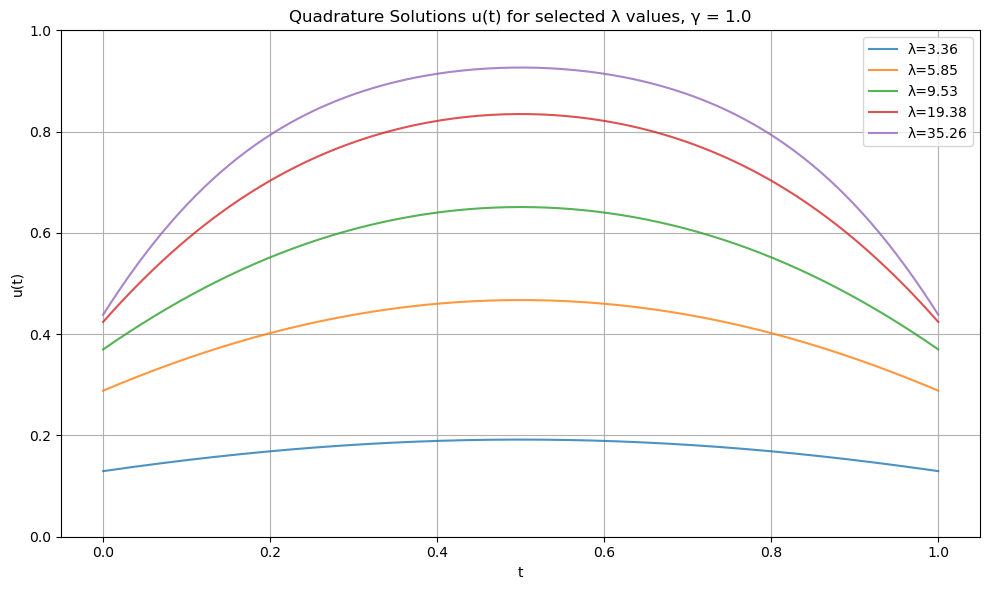

In [6]:
# Valid lambda values found after computing q and rho
selected_lambdas = [3.362515, 5.848052, 9.532301, 19.379977, 35.263987]

# Define the ODE
def ode1(t, u, rho, lambd):
    diff = F(rho) - F(u)
    return np.sqrt(2 * lambd * diff) if diff > 0 else 0.0

plt.figure(figsize=(10, 6))
for lam in selected_lambdas:
    # Find closest lambda in computed lambda_values
    arr = np.array(lambda_values)
    idx = np.nanargmin(np.abs(arr - lam))

    q = q_values[idx]
    rho = rho_values[idx]
    lambd = lambda_values[idx]

    if not np.isnan(lambd):
        sol = solve_ivp(ode1, [0, 0.5], [q], args=(rho, lambd),
                        dense_output=True, rtol=1e-9,
                        atol=1e-12)
        t_half = np.linspace(0, 0.5, 100)
        u_half = sol.sol(t_half)[0]
        t_full = np.concatenate([t_half, 1 - t_half[::-1]])
        u_full = np.concatenate([u_half, u_half[::-1]])

        plt.plot(t_full, u_full, label=f"λ={lam:.2f}", alpha=0.8)

plt.xlabel("t")
plt.ylabel("u(t)")
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.title(f"Quadrature Solutions u(t) for selected λ values, γ = {gamma}")
plt.tight_layout()
plt.show()

## 2.3 Construction of Sub- and Super-Solutions

We construct **sub-** and **super-solutions** using the eigenfunction $\phi(x)$. Consider the perturbed linear problem:

$$
\begin{cases}
-\phi''(x) = (\lambda r + \sigma) \phi(x), & x \in (0, 1), \\
-\phi'(0) + \sqrt{\lambda} \gamma \phi(0) = 0, \\
\phi'(1) + \sqrt{\lambda} \gamma \phi(1) = 0,
\end{cases}
$$

where $\sigma < 0$ is an auxiliary parameter. Let $\mu = \sqrt{\lambda r + \sigma}$, then the general solution is:

$$
0 = (\lambda \gamma^2 - \mu^2)\sin(\mu) + 2\sqrt{\lambda}\,\gamma\,\mu\cos(\mu),
$$

which satisfies the Robin boundary conditions and can be normalized so that $\|\phi\|_\infty = 1$.

Based on $\phi(x)$, we define:

- **Subsolution:** $\psi_{\text{sub}} = m_1 \phi$, with $m_1 \in \left(0, -\frac{\sigma}{\lambda}\right]$.  
- **Supersolution:** $\psi_{\text{sup}} = m_2 \phi$, with $m_2 = -\frac{\sigma}{\lambda \cdot \min \phi}$.

The signs of $\sigma$ and $\min \phi$ ensure these are valid pointwise bounds. The following inequalities hold:

$$
\begin{aligned}
-\psi_{\text{sub}}''(x) &\le \lambda \psi_{\text{sub}} (1 - \psi_{\text{sub}}), \\
-\psi_{\text{sup}}''(x) &\ge \lambda \psi_{\text{sup}} (1 - \psi_{\text{sup}}),
\end{aligned}
$$

with both $\psi_{\text{sub}}$ and $\psi_{\text{sup}}$ satisfying the boundary conditions.

**Theorem:**  
With $\lambda$ > $\lambda_1$, $ \sigma $ < 0, and $ \psi_{\text{sub}} $ < $ \psi_{\text{sup}} $, then a solution u exists such as:

$$
\psi_{\text{sub}}(x) \leq u(x) \leq \psi_{\text{sup}}(x)
$$


## 2.4 Numerical Computation and Visualization of Sub- and Super-Solutions

To quantify how the analytical bounds depend on the system parameters, we numerically compute the eigenfunction $\phi(x)$ and corresponding **sub-** and **super-solutions** for a range of $\lambda$ values.


### 2.4.1 Solving for the principal eigenvalue $\mu$ and computing $\sigma$
For each chosen value of $\lambda$, the eigenvalue parameter $\mu$ satisfies the transcendental equation derived from the Robin boundary conditions:
$$
f(\mu; \lambda, \gamma) = (\lambda \gamma^2 - \mu^2)\sin(\mu) + 2\sqrt{\lambda}\,\gamma\,\mu\cos(\mu) = 0.
$$

Once $\mu$ is obtained, we define
$$
\sigma = \mu^2 - \lambda,
$$
which measures the deviation from the linear eigenvalue. Negative $\sigma$ values indicate admissible perturbations that yield bounded nonlinear solutions.

In [7]:
# Chosen lambda values and gamma1 set to 1
gamma1 = 1.0
lambda_val = [3.362515, 5.848052,
              9.532301, 19.379977, 
              35.263987]

# Transcendental function to solve for mu
def f(mu, lambda_val, gamma1):
    term1 = (lambda_val * gamma1**2 - mu**2) * np.sin(mu)
    term2 = 2 * np.sqrt(lambda_val) * gamma1 * mu * np.cos(mu)
    return term1 + term2

# Find root mu for the principal eigenvalue
def find_mu(lambda_val, gamma1):
    mus = np.linspace(0.1, 20, 1000)
    for i in range(len(mus) - 1):
        a, b = mus[i], mus[i + 1]
        if f(a, lambda_val, gamma1) * f(b, lambda_val, gamma1) < 0:
            result = root_scalar(f, args=(lambda_val, gamma1), bracket=(a, b), method='brentq')
            if result.converged:
                return result.root
    return None

### 2.4.2 Constructing the eigenfunction with the scaled super and sub solution set
The corresponding eigenfunction is
$$
\phi(x) = \cos(\mu x) + C\sin(\mu x), 
\quad 
C = \frac{\sqrt{\lambda}\,\gamma}{\mu},
$$
and is normalized such that $\|\phi\|_{\infty} = 1$.

Using $\sigma$ and the normalized $\phi(x)$, we define
$$
\psi_{\text{sub}}(x) = m_1\,\phi(x), \qquad 
\psi_{\text{sup}}(x) = m_2\,\phi(x),
$$
where
$$
m_1 = \left(0, -\frac{\sigma}{\lambda}\right], 
\qquad
m_2 = -\frac{\sigma}{\lambda\,\min(\phi)}.
$$
These satisfy
$$
-\psi_{\text{sub}}''(x) \le \lambda \psi_{\text{sub}}(1 - \psi_{\text{sub}}), 
\qquad
-\psi_{\text{sup}}''(x) \ge \lambda \psi_{\text{sup}}(1 - \psi_{\text{sup}}),
$$
ensuring
$$
\psi_{\text{sub}}(x) \le u(x) \le \psi_{\text{sup}}(x), 
\quad x \in (0, 1).
$$

Each value of $\lambda$ is plotted below with:

-The base eigenfunction $\phi(x)$.

-The **Super** and **Sub** solutions which simply scale the eigenfunction.

λ ≈ 3.362515, σ ≈ -0.585773, μ ≈ 1.666356, m1 ≈ 0.087103, m2 ≈ 0.259033, sub_min = 0.058579, sup_max = 0.259033 min φ ≈ 0.672527
λ ≈ 5.848052, σ ≈ -2.460652, μ ≈ 1.840489, m1 ≈ 0.210382, m2 ≈ 0.694760, sub_min = 0.127413, sup_max = 0.694760 min φ ≈ 0.605626
λ ≈ 9.532301, σ ≈ -5.554351, μ ≈ 1.994480, m1 ≈ 0.291344, m2 ≈ 1.073835, sub_min = 0.158090, sup_max = 1.073835 min φ ≈ 0.542623
λ ≈ 19.379977, σ ≈ -14.492380, μ ≈ 2.210791, m1 ≈ 0.373901, m2 ≈ 1.666294, sub_min = 0.167800, sup_max = 1.666294 min φ ≈ 0.448781
λ ≈ 35.263987, σ ≈ -29.602438, μ ≈ 2.379401, m1 ≈ 0.419726, m2 ≈ 2.256968, sub_min = 0.156112, sup_max = 2.256968 min φ ≈ 0.371938


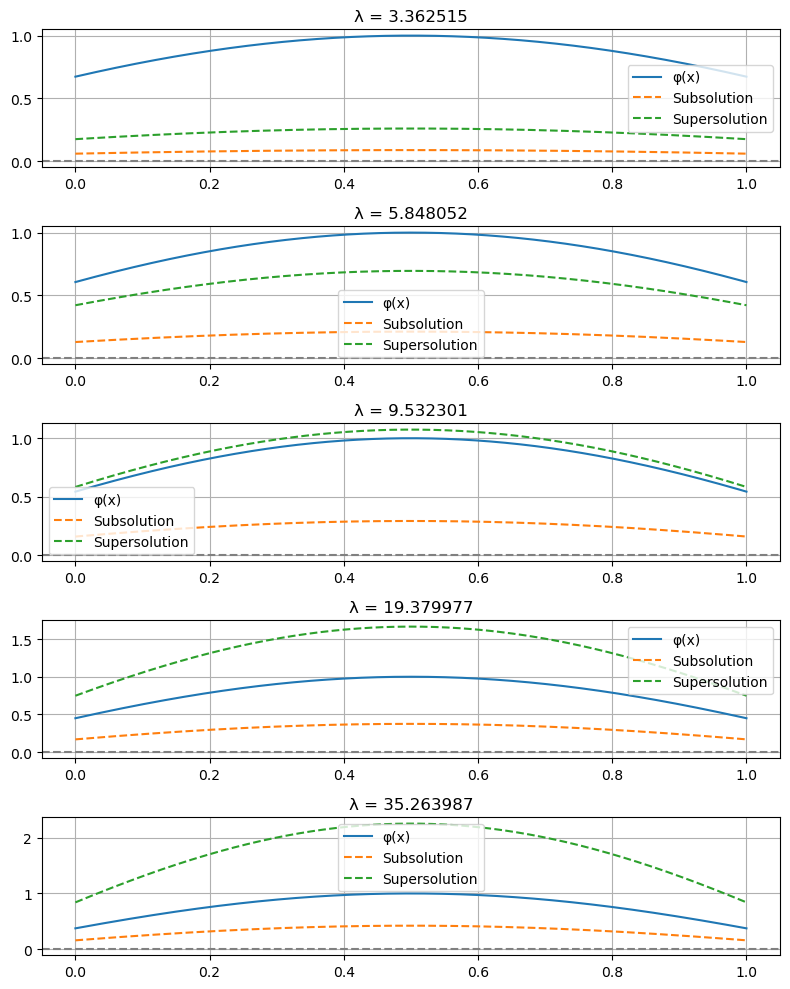

In [8]:
fig, axs = plt.subplots(len(lambda_val), 1, figsize=(8, 2*len(lambda_val)))

for idx, lam in enumerate(lambda_val):
    mu = find_mu(lam, gamma1)
    if mu is None:
        print(f"Could not find a valid root for mu for λ={lam}")
        continue
    C = np.sqrt(lam) * gamma1 / mu
    phi = lambda x: np.cos(mu * x) + C * np.sin(mu * x)
    x_vals = np.linspace(0, 1, 1000)
    phi_vals = phi(x_vals)
    phi_vals_normalized = phi_vals / np.max(np.abs(phi_vals))
    phi_min = np.min(phi_vals_normalized)

    m1 = (-(mu**2 - lam) / lam) * 0.5        # m1 is any value (0, -sigma/lambda] so we pick half the max
    m2 = (-(mu**2 - lam) / (lam * phi_min))

    sub_phi = phi_vals_normalized * m1
    super_phi = phi_vals_normalized * m2

    print(f"λ ≈ {lam}, σ ≈ {mu**2 - lam:.6f}, μ ≈ {mu:.6f}, m1 ≈ {m1:.6f}, m2 ≈ {m2:.6f}, sub_min = {np.min(sub_phi):.6f}, sup_max = {np.max(super_phi):.6f} min φ ≈ {phi_min:.6f}")

    axs[idx].plot(x_vals, phi_vals_normalized, label="φ(x)")
    axs[idx].plot(x_vals, sub_phi, '--', label="Subsolution")
    axs[idx].plot(x_vals, super_phi, '--', label="Supersolution")
    axs[idx].set_title(f"λ = {lam}")
    axs[idx].axhline(0, color='gray', linestyle='--')
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

### **Important Note**

Since u(x) exists with these parameters and is between the **Super** and **Sub** solutions graphed, using the solutions to bound our network greatly reduces the search area for our network.

## 3 Physics-Informed Neural Networks vs Standard Neural Networks

Standard neural networks aim to approximate functions by minimizing the difference between predicted and observed data. In many scientific and engineering problems, however, data may be sparse, noisy, or expensive to obtain. In such cases, standard networks struggle to produce physically meaningful solutions.

Physics-Informed Neural Networks (PINNs) offer a solution by incorporating known physical laws directly into the learning process. Instead of relying purely on data, a PINN enforces the governing differential equations and boundary conditions as part of the loss function. This ensures that the learned solution not only fits the data but also satisfies the underlying physics.

### Key Differences:

| Aspect                     | Standard NN                     | PINN                                     |
|-----------------------------|---------------------------------|-----------------------------------------|
| Loss Function               | Data mismatch (MSE, MAE, etc.) | PDE residual + boundary conditions      |
| Data Requirement            | High                            | Can work with sparse data               |
| Physical Consistency        | Not guaranteed                  | Enforced through PDE and BCs            |
| Generalization Outside Data | Poor                            | Often better due to physics constraints |

In this section, we will:

1. Define a neural network capable of approximating the solution \(u(x)\).  
2. Construct a loss function that incorporates both the PDE residual and boundary conditions.  
3. Train the network to produce solutions that are physically consistent with the reaction-diffusion system we studied earlier.

This approach allows us to leverage both the flexibility of neural networks and the rigor of physics-based modeling, producing reliable and interpretable results even when data is limited.


### 3.1 Network Class

The neural network used in the PINN is structurally similar to a standard feedforward neural network. It consists of:

- An input layer accepting the independent variable \(x\).  
- Several hidden layers with nonlinear activation functions (Tanh).  
- An output layer producing the predicted solution \(u(x)\).

The network class in PyTorch looks like this:

In [9]:
class Basic_Net(nn.Module):
    def __init__(self):
        super(Basic_Net, self).__init__()
        
        self.hidden = nn.Sequential(
            nn.Linear(1, 32), # Input layer
            nn.Tanh(),         
            nn.Linear(32, 32), # First hidden layer
            nn.Tanh(),
            nn.Linear(32, 32),  # Second hidden layer
            nn.Tanh(),
            nn.Linear(32, 1), # Output layer
        )

    def forward(self, x):
        return self.hidden(x)

### 3.2 Loss Function: Physics-Informed Neural Networks vs Standard Neural Networks

Unlike standard neural networks, which minimize a data loss (difference between predicted and observed values), a PINN incorporates the governing PDE and boundary conditions directly into the loss function.

#### Components:

1. **Differential Equation Residual**  
   - Compute derivatives using automatic differentiation.  
   - For our reaction-diffusion equation:  
     $$
     f(t) = -u''(t) - \lambda u(t)(1-u(t))
     $$  
   - Minimize the mean squared residual:  
     $$
     \text{Loss}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^{N} f(t_i)^2
     $$

2. **Boundary Conditions (Robin BC)**  
   - Split into two separate terms for clarity:

     BC at x = 0:  
     $$
     -u'(0) + \sqrt{\lambda}\,\gamma\, u(0) = 0, \quad
     \text{Loss}_{\text{BC(0)}} = \big(-u'(0) + \sqrt{\lambda}\,\gamma\, u(0)\big)^2
     $$

     BC at x = 1:  
     $$
     u'(1) + \sqrt{\lambda}\,\gamma\, u(1) = 0, \quad
     \text{Loss}_{\text{BC(1)}} = \big(u'(1) + \sqrt{\lambda}\,\gamma\, u(1)\big)^2
     $$

   - Total boundary loss:  
     $$
     \text{Loss}_{\text{BC}} = \text{Loss}_{\text{BC(0)}} + \text{Loss}_{\text{BC(1)}}
     $$

3. **Total Loss**  
   - Combines PDE residual and boundary terms:  
     $$
     \text{Loss}_{\text{total}} = \text{Loss}_{\text{PDE}} + \text{Loss}_{\text{BC}}
     $$

This decomposition helps implement and monitor each BC contribution individually during PINN training.

In [10]:
def loss_function(u_pred, x, net):
    u_x = u_pred  # u(x)

    # First derivative u'(x)
    u_x_grad = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True)[0]

    # Second derivative u''(x)
    u_x_grad2 = torch.autograd.grad(u_x_grad, x, torch.ones_like(u_x_grad), create_graph=True, allow_unused=True)[0]

    # Define the differential equation residual: -u''(x) - lambda*u(x)(1 - u(x))
    f = - u_x_grad2 - lambd *  u_x * (1 - u_x)

    # Compute the loss for the differential equation
    loss_eq = torch.mean(f**2)

    # Enforce Robin boundary conditions
    x_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    x_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True)
    u_0 = net(x_0)
    u_1 = net(x_1)

    u_0_grad = torch.autograd.grad(u_0, x_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, x_1, torch.ones_like(u_1), create_graph=True)[0]

    # Robin boundary conditions
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd)) * gamma1 * u_1) ** 2).mean()

    return loss_eq, loss_bc_1, loss_bc_0

### 3.3 Training the Physics-Informed Neural Network

Training a Physics-Informed Neural Network (PINN) differs from standard neural networks in key ways:

1. **No labeled data:**  
   PINNs are trained using *collocation points* in the domain rather than input-output pairs.  
   The loss is computed from the PDE residual and boundary conditions, not from data error.

2. **Automatic differentiation:**  
   PyTorch computes derivatives $u'(x)$ and $u''(x)$ via `torch.autograd`, allowing the network to directly minimize the physics residual.

3. **Loss composition:**  
   The total loss combines:  
   $$
   \mathcal{L}_\text{total} = \mathcal{L}_\text{PDE} + \mathcal{L}_\text{BC0} + \mathcal{L}_\text{BC1}
   $$
   where:  
   - $\mathcal{L}_\text{PDE}$ enforces the differential equation  
   - $\mathcal{L}_\text{BC0}$ enforces the Robin boundary condition at zero
   - $\mathcal{L}_\text{BC1}$ enforces the Robin boundary condition at one 

4. **Early stopping and gradient clipping:**  
   To prevent overfitting and instability during training, we apply gradient clipping and early stopping based on loss stagnation.

The following cell defines the full training loop.

In [11]:
def train_model(net, optimizer, scheduler=None, n_epochs=3000, patience=500):
    x_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    x_values.requires_grad_()
    losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(x_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, x_values, net)    # Compute losses

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0) # Gradient clipping to smooth training
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        loss_val = total_loss.item()

        if epoch >= 50:      # Losses are high initially, so ignore first 50 epochs as the model will improve rapidly
            losses.append(total_loss.item())
        
        if loss_val < best_loss:    # Logic for early stopping
            best_loss = loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} | Best loss: {best_loss:.8f}")
            break
        
    best_loss = loss_val
    print(f"Training completed after {epoch+1} epochs | Final loss: {best_loss:.8f}")

    return net(x_values).detach().cpu().numpy().flatten(), losses

### 3.4 Benchmarking the PINN Solution with Quadrature Method

Once the PINN has been trained, it is important to validate its predictions against the reference solutions obtained from the quadrature method. This ensures that the network not only minimizes the loss function but also produces physically consistent solutions.

The workflow for benchmarking is as follows:

1. Select reference parameter sets: Choose representative (q, $\rho, \lambda$) triplets obtained from the quadrature method.

2. Train the network: For each parameter set, initialize and train the neural network using the previously defined PINN loss function.

3. Track the training losses for the network to visualize learning or overfitting.

4. Compute quadrature solutions: Solve the corresponding boundary value problem using `solve_ivp` to generate the reference solution.

5. Compare predictions: Plot the PINN solution against the quadrature solution over the full domain to visually inspect accuracy.



RUNNING MODEL: λ = lambda_3.36
Early stopping at epoch 2439 | Best loss: 0.00000002
Training completed after 2440 epochs | Final loss: 0.00000013


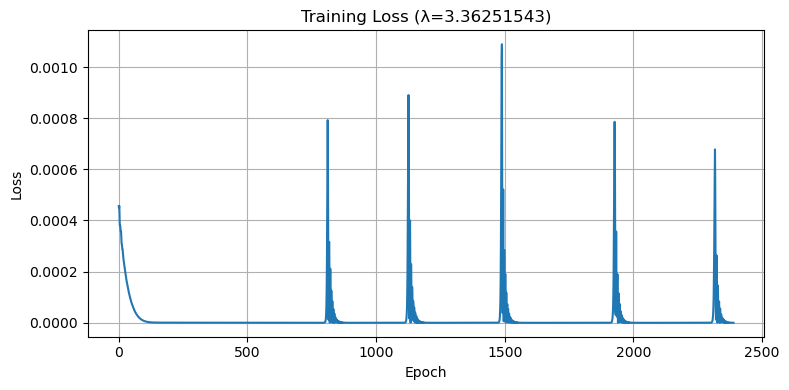

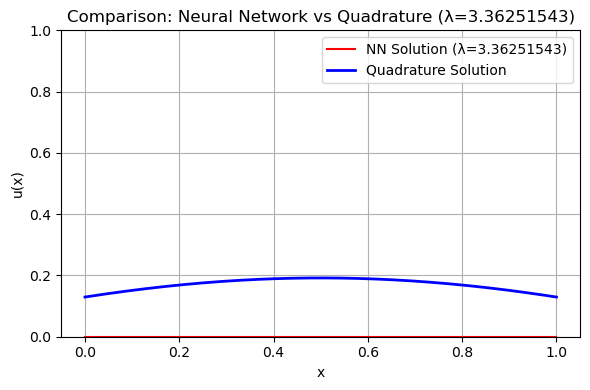


RUNNING MODEL: λ = lambda_5.85
Training completed after 5000 epochs | Final loss: 0.00000001


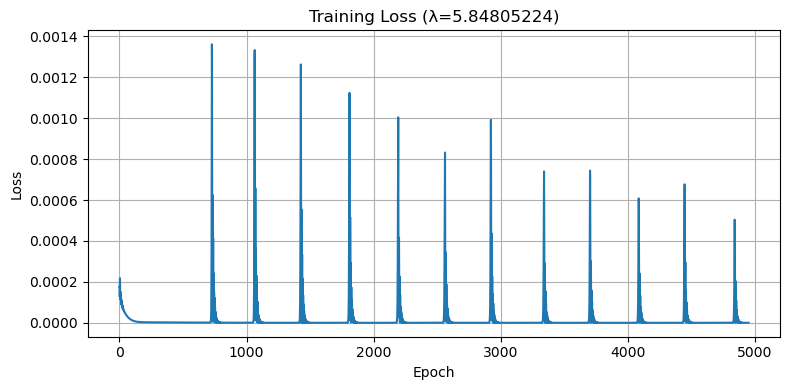

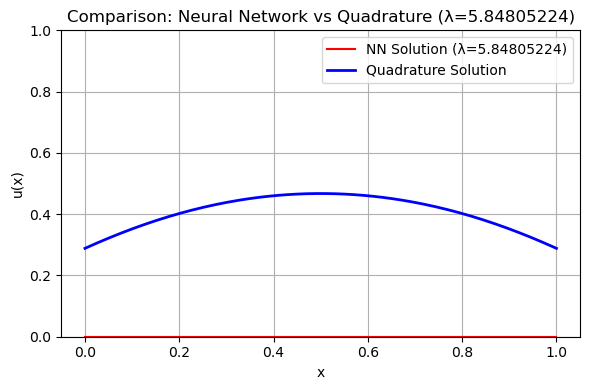


RUNNING MODEL: λ = lambda_9.53
Training completed after 5000 epochs | Final loss: 0.00000106


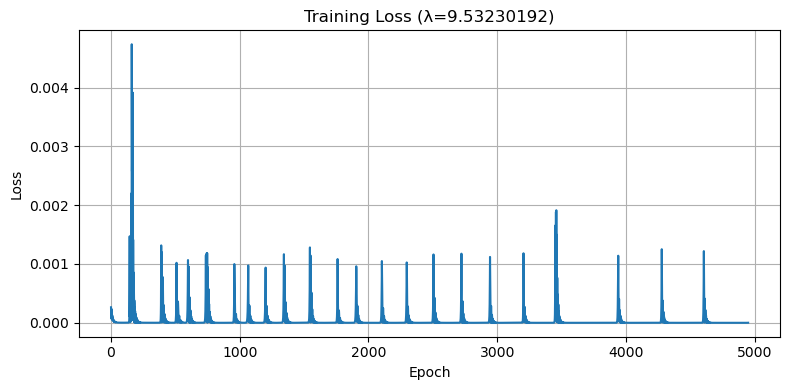

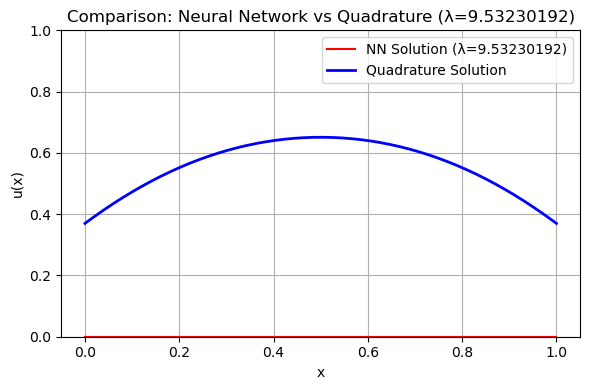


RUNNING MODEL: λ = lambda_19.38
Early stopping at epoch 784 | Best loss: 0.00003596
Training completed after 785 epochs | Final loss: 0.00502674


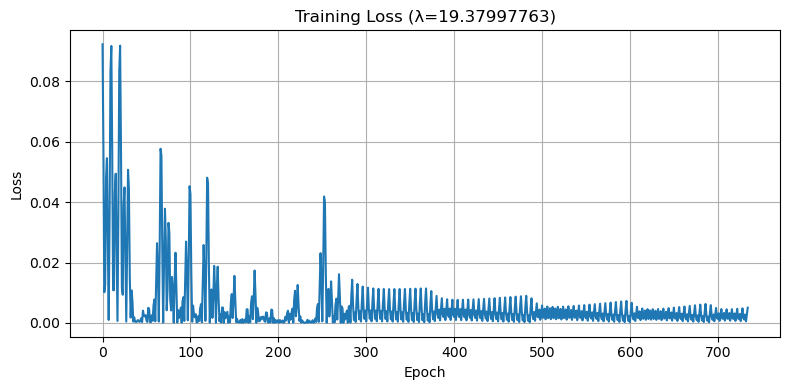

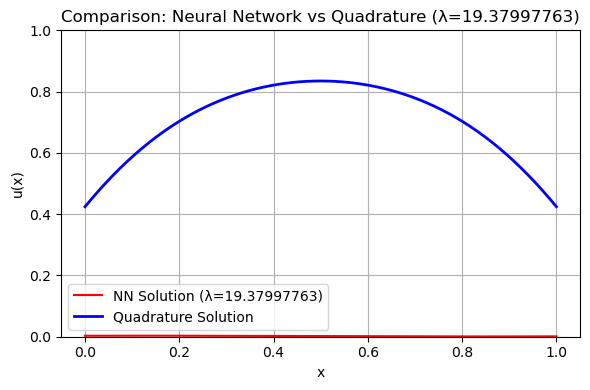


RUNNING MODEL: λ = lambda_35.26
Early stopping at epoch 1415 | Best loss: 0.00000458
Training completed after 1416 epochs | Final loss: 0.00057830


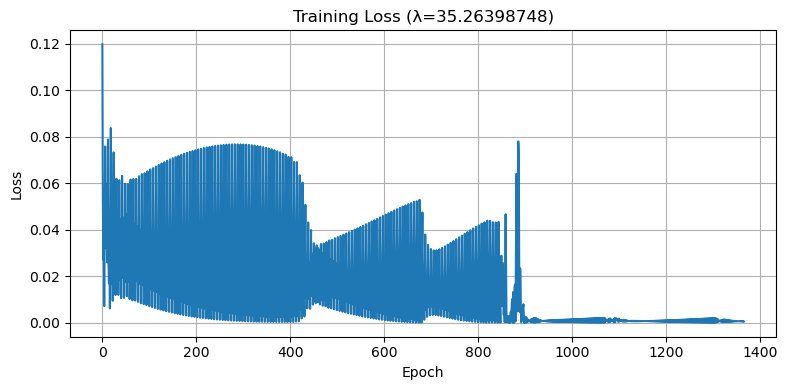

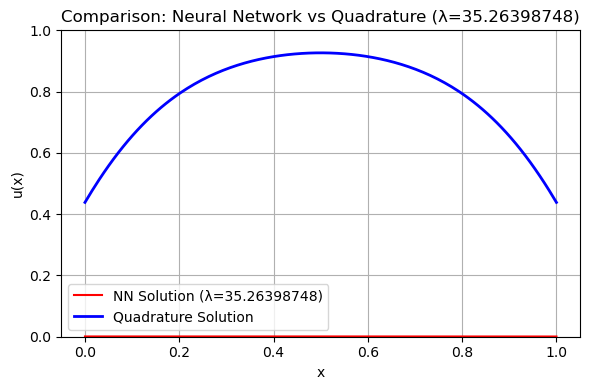

In [12]:
# Parameters for training and testing
parameter_sets = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
    },
    {
        'name': 'lambda_5.85',
        'lambd': 5.84805224,
        'rho': 0.46734694,
        'u0': 0.28840600,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,

    },
    {
        'name': 'lambda_19.38',
        'lambd': 19.37997763,
        'rho': 0.83469388,
        'u0': 0.42421198,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
    }
]


for params in parameter_sets:
    print("\n" + "="*80)
    print(f"RUNNING MODEL: λ = {params['name']}")
    print("="*80)
    
    # Extract parameters
    lambd = params['lambd']
    rho = params['rho']
    u0 = params['u0']

    net = Basic_Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    output, losses = train_model(net, optimizer, n_epochs=5000)

    # Plotting training loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.title(f"Training Loss (λ={lambd})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    x_test = np.linspace(0, 1, 500)
    sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), dense_output=True, rtol=1e-9, atol=1e-12)
    x1 = np.linspace(0, 0.5, 100)
    u1 = sol1.sol(x1)
    x2 = 1 - x1
    u2 = u1[:, ::-1]

    x_quad = np.concatenate([x1, x2[::-1]])
    u_quad = np.concatenate([u1.flatten(), u2.flatten()])

    plt.figure(figsize=(6, 4))
    plt.plot(x_test, output, label=f"NN Solution (λ={lambd})", color="red")
    plt.plot(x_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"Comparison: Neural Network vs Quadrature (λ={lambd})")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3.5 Results

The Basic_Net fails at handling the both the boundary conditions and the PDE residuals. This is common in many basic PINN structures as the network finds the trivial solution (usually 0) to be optimal and gets stuck in a local minima. 

This experiment is usually done with ~20 runs of a single model each to test random initialization of each network. For brevity we are showcasing that a basic model without bounds fails. 

During testing and validation many parameters were tested including:

- Architecture of depth and width of the network: [1, 16, 1] -> [1, 64, 64, 64, 64, 1]

- Activation Functions: Sigmoid, Tanh, Relu, Gelu, Silu, SoftMax

- Epochs Lengths: up to 30,000 epochs with their resulting loss values were analyzed

- Learning Rates and Schedulers: Between 0.1 - 0.00001 LR with different schedulers including StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, and CosineAnnealingWarmRestarts

## 4 Applying Bounds and Innovations to Network

In the previous section, we observed that a standard Physics-Informed Neural Network (PINN) often fails to converge for the nonlinear reaction–diffusion boundary value problem. The network tends to collapse toward trivial or nonphysical solutions, largely due to the stiffness of the equation and the flatness of the loss landscape near the boundaries.

To mitigate this, we now incorporate analytical constraints derived from **sub- and super-solutions**. These bounds restrict the neural network’s predictions to a physically admissible region, guiding the optimization process away from unstable or nonphysical minima.

This section introduces two key innovations:

1. **Bounding the Network Output**: The predicted field $u(x)$ is constrained to remain between the analytical subsolution $u_{\text{sub}}(x)$ and supersolution $u_{\text{sup}}(x)$. This ensures that all predictions are physically valid and consistent with the underlying differential equation.

2. **Embedding Analytical Structure into the Neural Architecture**: Instead of allowing the network to learn an unrestricted function, we reparameterize its output using the known bounds:

   $$
   u_{\text{bounded}}(x) = u_{\text{sub}}(x) + [u_{\text{sup}}(x) - u_{\text{sub}}(x)] * {\text{Sig}}(N(x))
   $$

   where ${\text{Sig}}$ is a sigmoid activation that ensures  

   $( u_{\text{bounded}}(x) \in [u_{\text{sub}}(x), u_{\text{sup}}(x)])$.  
   This transformation enforces the bounds by construction and stabilizes training across all parameter regimes.


### 4.1 **Super** and **Sub** Solutions

We first compute the **sub- and super-solutions** numerically for each eigenvalue $\lambda$ .  
These are constructed from the principal eigenfunction of the linearized operator and define pointwise lower and upper bounds for $u(x)$.

The sub- and super-solutions serve as analytical envelopes within which the true physical solution must lie. They are derived from the perturbed linear problem and normalized to satisfy the same boundary conditions.

For each $\lambda$, we compute the eigenfunction, normalize it, and extract the minimum and maximum values to define:

$$
u_{\text{sub}}(x) \leq u(x) \leq u_{\text{sup}}(x)
$$

These bounds will later be integrated directly into the neural network, ensuring that training remains both stable and physically consistent across all parameter regimes.

This analytical bounding forms the foundation of the bounded-PINN approach, bridging the theoretical eigenstructure of the problem with the flexibility of neural networks.

In [13]:
# Find super and sub solution values from eigenfunction
def eigenfunction_root(mu, lambd, gamma1=1):
    term1 = (lambd * gamma1**2 - mu**2) * np.sin(mu)
    term2 = 2 * np.sqrt(lambd) * gamma1 * mu * np.cos(mu)
    return term1 + term2

def compute_subsolution(lambd, gamma1=1, resolution=1000):
    # Find mu numerically
    mus = np.linspace(0.1, 20, 1000)
    for i in range(len(mus) - 1):
        a, b = mus[i], mus[i + 1]
        if eigenfunction_root(a, lambd, gamma1=1) * eigenfunction_root(b, lambd, gamma1) < 0:
            result = root_scalar(eigenfunction_root, args=(lambd, gamma1), bracket=(a, b), method='brentq')
            if result.converged:
                mu = result.root
                break
    else:
        raise ValueError(f"Could not find a valid mu for λ={lambd}")

    # Define normalized phi(x) = cos(mu x) + C sin(mu x)
    C = np.sqrt(lambd) * gamma1 / mu
    x_vals = np.linspace(0, 1, resolution)
    phi_vals = np.cos(mu * x_vals) + C * np.sin(mu * x_vals)
    phi_vals /= np.max(np.abs(phi_vals))  # Normalize

    # Construct subsolution
    m1 = (-(mu**2 - lambd) / lambd) * 0.5           # m1 is any value (0, -sigma/lambda] so we pick half the max
    m2 = -(mu**2 - lambd) / (lambd * np.min(phi_vals))
    sup_phi = phi_vals * m2
    sub_phi = phi_vals * m1
    sub_min = np.min(sub_phi)
    sup_max = np.max(sup_phi)

    return sub_min, sup_max

### 4.2 Scaling Output by Sigmoid

To ensure that the neural network predictions remain within physically meaningful bounds, we scale the final activation function using a sigmoid. By mapping the standard sigmoid output to the interval defined by the previously computed **sub- and super-solutions**, the network is constrained to search only within the analytically valid range:

$$
u_\text{scaled}(x) = u_{\text{sub}}(x) + \big(u_{\text{sup}}(x) - u_{\text{sub}}(x)\big) \cdot \text{Sig}(\text{NN output})
$$

This approach has several benefits:

1. **Constrains the solution space:**  
   The network cannot produce outputs outside $[u_{\text{sub}}(x), u_{\text{sup}}(x)]$, limiting the space to fall into a local minima.

2. **Improves training stability:**  
   By reducing the effective search space, the optimizer focuses on feasible regions, speeding up convergence.

3. **Preserves boundary consistency:**  
   The scaled sigmoid ensures that the network output naturally respects the bounds derived from the eigenfunction analysis.

#### Visualization of Scaled Sigmoids

For a range of representative $(\lambda, q, \rho)$ triplets, we plot the scaled sigmoid:

- The blue curve represents the **scaled sigmoid output**, constrained between $u_{\text{sub}}(x)$ and $u_{\text{sup}}(x)$.
- The red dashed line is the $q$ value which is the true minimum of the function.
- The green dashed line is the $\rho$ value which is the true maximum of the function.

These plots illustrate how different eigenvalues $\lambda$ affect the scaling and the resulting search space for the network. By using the sigmoid as a bounded output, the network is guided toward the true solution of the equation, which is can be seen as every min and max of the equation are contained in the restricted space.

sub_min ≈ 0.058579, sup_max ≈ 0.259033, lambda = 3.362515, q = 0.129504, ρ = 0.191836
sub_min ≈ 0.127413, sup_max ≈ 0.694760, lambda = 5.848052, q = 0.288406, ρ = 0.467346
sub_min ≈ 0.158090, sup_max ≈ 1.073835, lambda = 9.532301, q = 0.369875, ρ = 0.65102
sub_min ≈ 0.167800, sup_max ≈ 1.666294, lambda = 19.379977, q = 0.424211, ρ = 0.834693
sub_min ≈ 0.156112, sup_max ≈ 2.256968, lambda = 35.263987, q = 0.438387, ρ = 0.92653


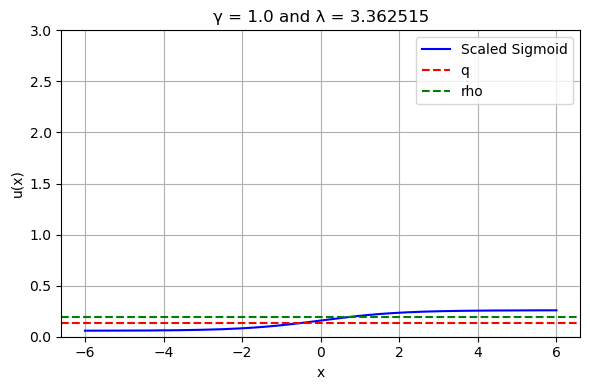

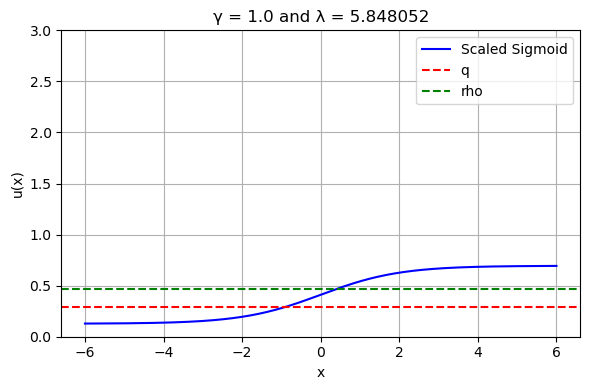

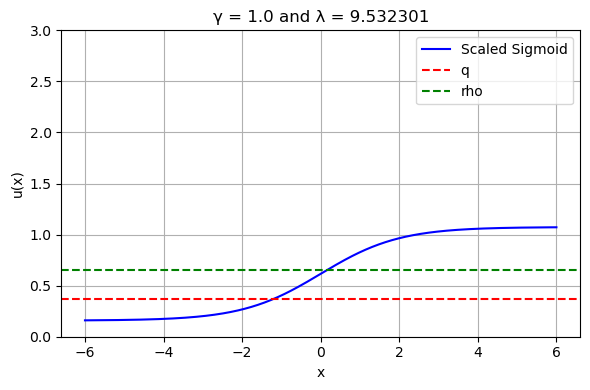

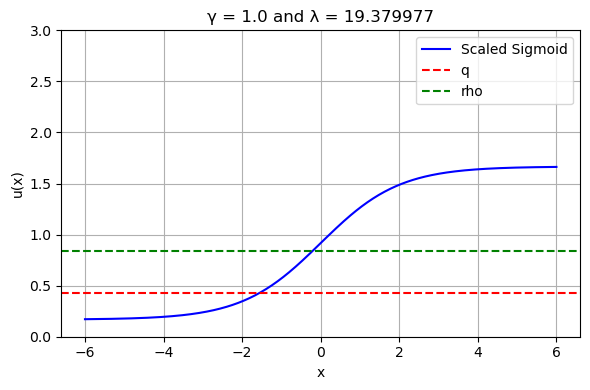

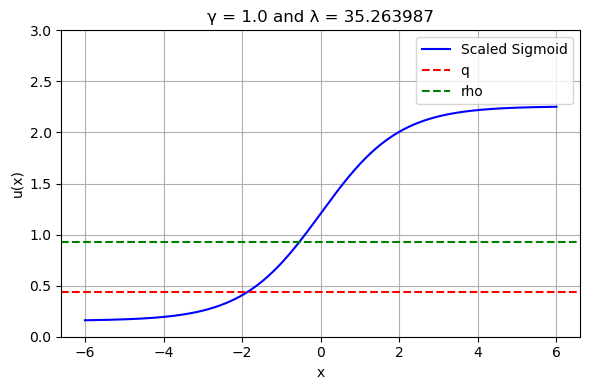

In [14]:
# (lambda, q, rho, sub_min, sup_max)
input_list = [
    (3.362515, 0.129504, 0.191836),
    (5.848052, 0.288406, 0.467346),
    (9.532301, 0.369875, 0.651020),
    (19.379977, 0.424211, 0.834693),
    (35.263987, 0.438387, 0.926530)
]

output_list = []

for entry in input_list:
    lambd = entry[0]  # First element: lambda
    q = entry[1]      # Second element: q
    rho = entry[2]    # Third element: rho

    # Compute sub_min and sup_max for this lambda
    sub_min, sup_max = compute_subsolution(lambd, gamma1)
    print(f"sub_min ≈ {sub_min:.6f}, sup_max ≈ {sup_max:.6f}, lambda = {lambd}, q = {q}, ρ = {rho}")

    # Append full tuple (lambda, q, rho, sub_min, sup_max)
    output_list.append((lambd, q, rho, sub_min, sup_max))

# Define x values for plotting
x = np.linspace(-6, 6, 500)

for i, (lambd, q, rho, sub_min, sup_max) in enumerate(output_list):
    fig, ax = plt.subplots(figsize=(6, 4))  # One figure per plot

    sig = expit(x)
    scaled_sig = sub_min + (sup_max - sub_min) * sig

    # Plot scaled sigmoid
    ax.plot(x, scaled_sig, label='Scaled Sigmoid', color='blue')

    # Horizontal lines
    ax.axhline(q, color='red', linestyle='--', linewidth=1.5, label='q')
    ax.axhline(rho, color='green', linestyle='--', linewidth=1.5, label='rho')

    # Title and labels
    ax.set_title(f"γ = {gamma1} and λ = {lambd}")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.set_ylim(0, 3)
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

### 4.3 PINN Architecture and Custom Activation

We define the Physics-Informed Neural Network (PINN) to respect the bounds defined by the **sub- and super-solutions**.  

### Key Features

1. **Custom Periodic Activation (`CosActivation`)**  

   We performed extensive experiments to evaluate different activation functions under extreme $\lambda$ values. The table below summarizes the number of successfully trained models (out of 20 attempts) for each activation function:

| Activation | λ = 3, Super-Solution | λ = 35, Super-Solution |
|------------|----------------------|-----------------------|
| Tanh       | 0/20                 | 20/20                 |
| Sigmoid    | 0/20                 | 20/20                 |
| Cos        | 20/20                | 20/20                 |
| ReLU       | 0/20                 | 0/20                  |
| SiLU       | 13/20                | 20/20                 |
| GELU       | 20/20                | 20/20                 |
| Softplus   | 0/20                 | ~18/20                |

   **Observations:**
   - The `CosActivation` function consistently succeeds across all λ values and bounds, demonstrating superior stability and compatibility with the PDE constraints.  
   - Smooth, bounded activations like GELU and SiLU perform well in high-λ regimes but occasionally fail under low-λ or tight-bound conditions.  
   - Standard activations like Tanh, Sigmoid, ReLU, and Softplus struggle when the network must respect tight analytical bounds, especially at low λ.  

   These results validate our choice of a custom periodic activation: it reliably enables the PINN to satisfy both the PDE residual and the bound constraints, while supporting smooth approximations for higher-order derivatives.

   The `CosActivation` is defined as:

   $$
   act(x) = 0.5 \left( 1 - \cos(2 \pi x) \right)
   $$

   Smooth, periodic activations help the network better approximate higher-order derivatives, which is crucial for enforcing PDE residuals via automatic differentiation.

2. **Network (`Net`)**  

   - Takes `sub_min` and `sup_max` (bounds from sub-/super-solutions) and constrains the output via sigmoid scaling from the previous section:

     $$
     u_\theta(x) = u_{\text{sub}} + u_{\text{sup}} - u_{\text{sub}} \cdot \text{sigmoid}(\text{raw\_output})
     $$

   - Hidden layers are built with `CosActivation` units.  
   - Guarantees that the network output stays within analytically derived bounds.

---

All networks used the CosActivation function with the sigmoid output scaling. None of the architectures failed; all converged. The table below summarizes the average error and average training time for each architecture:

| Architecture | Average Error | Average Training Time (s) |
|--------------|---------------|--------------------------|
| [1, 40, 60, 20, 1]          | 0.001030 | 80.30  |
| [1, 16, 16, 1]              | 0.003134 | 59.72  |
| [1, 16, 16, 16, 1]          | 0.000730 | 77.40  |
| [1, 16, 16, 16, 16, 1]      | 0.001049 | 96.23  |
| [1, 32, 32, 1]              | 0.002111 | 59.21  |
| [1, 32, 32, 32, 1]          | 0.000593 | 77.19  |
| [1, 32, 32, 32, 32, 1]      | 0.001580 | 96.35  |
| [1, 64, 64, 1]              | 0.000975 | 59.34  |
| [1, 64, 64, 64, 1]          | 0.002146 | 77.82  |
| [1, 64, 64, 64, 64, 1]      | 0.005656 | 97.32  |

**Observations:**
- **Fastest convergence:** Shallow architectures like `[1,16,16,1]` and `[1,32,32,1]` train in under 60 seconds but have slightly higher average error.  
- **Most accurate:** Medium-width/depth networks such as `[1,32,32,32,1]` and `[1,16,16,16,1]` achieve the lowest average error (~0.0006–0.0007) with moderate training times (~77 s).  
- **Deepest/widest networks:** `[1,64,64,64,64,1]` and `[1,16,16,16,16,1]` take the longest to train and do not always produce lower error, highlighting diminishing returns with excessive depth/width.


In [15]:
class CosActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
      x = self.linear(x)
      return 0.5 * (1 - torch.cos(2 * np.pi * x))

In [16]:
class Net(nn.Module):
    def __init__(self, sub_min, sup_max):
        super(Net, self).__init__()
        self.sub_min = sub_min
        self.sup_max = sup_max
        
        self.hidden = nn.Sequential(
            CosActivation(1, 32),
            CosActivation(32, 32),
            CosActivation(32, 32),
            nn.Linear(32, 1)
        )        

        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.sub_min + (self.sup_max - self.sub_min) * self.output_activation(raw)

### 4.4 Training and Validation

After defining the network architecture, the next step is to train the PINN and validate its predictions against reference solutions obtained via numerical quadrature. This ensures that the network not only minimizes the loss function but also produces physically meaningful results.

The workflow for training and validation is as follows:

1. Select parameter sets: 
   Use the same representative parameter sets for $\lambda$, $\rho$, and $q$.

2. Compute sub- and super-solution bounds:  
   For each $\lambda$, determine the analytical bounds `sub_min` and `sup_max` to constrain the network output.

3. Initialize and train the network:
   Build the network with `CosActivation` hidden layers and sigmoid output scaling. Train using the Adam optimizer for 5000 epochs, tracking the loss at each step.

4. Monitor training loss:  
   Plot the loss curve to ensure convergence and detect potential overfitting.

5. Compute reference quadrature solutions:  
   Solve the corresponding boundary value problem using `solve_ivp` to generate a high-accuracy reference solution over the domain.

6. Compare network predictions to reference:  
   Plot the PINN solution against the quadrature solution to visually assess accuracy and confirm that the network output stays within the analytical bounds.

This procedure provides both quantitative (loss convergence) and qualitative (solution comparison) validation, demonstrating that the PINN can reliably approximate the solution while respecting the sub-/super-solution constraints.



RUNNING MODEL: λ = lambda_3.36
Using sub_min = 0.058579, sup_max = 0.259033 for λ = 3.36251543
Early stopping at epoch 3537 | Best loss: 0.00000126
Training completed after 3538 epochs | Final loss: 0.00000672


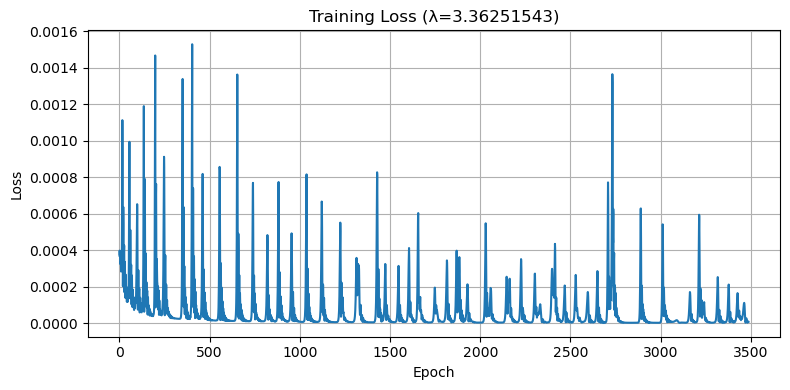

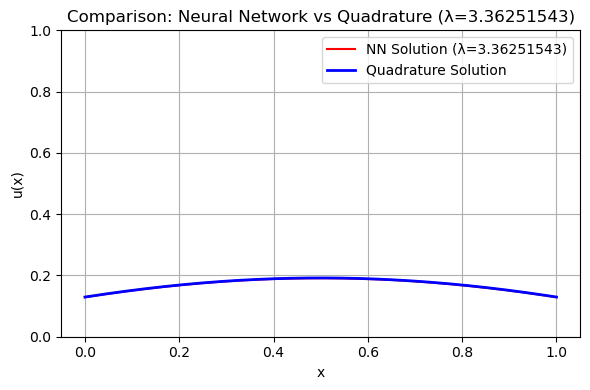


RUNNING MODEL: λ = lambda_5.85
Using sub_min = 0.127413, sup_max = 0.694760 for λ = 5.84805224
Early stopping at epoch 2319 | Best loss: 0.00008540
Training completed after 2320 epochs | Final loss: 0.00124930


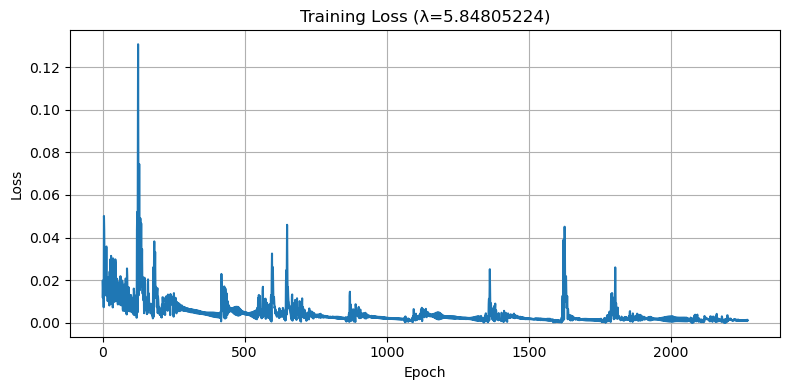

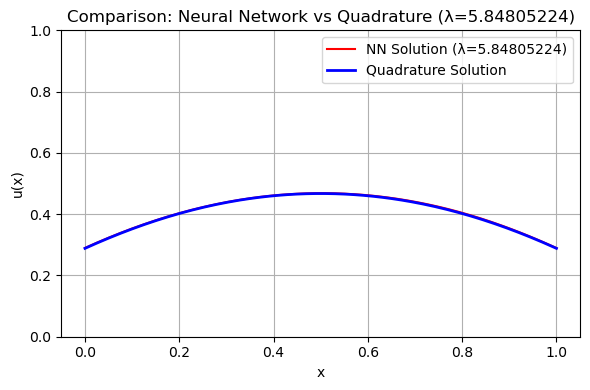


RUNNING MODEL: λ = lambda_9.53
Using sub_min = 0.158090, sup_max = 1.073835 for λ = 9.53230192
Early stopping at epoch 1884 | Best loss: 0.00140946
Training completed after 1885 epochs | Final loss: 0.01285626


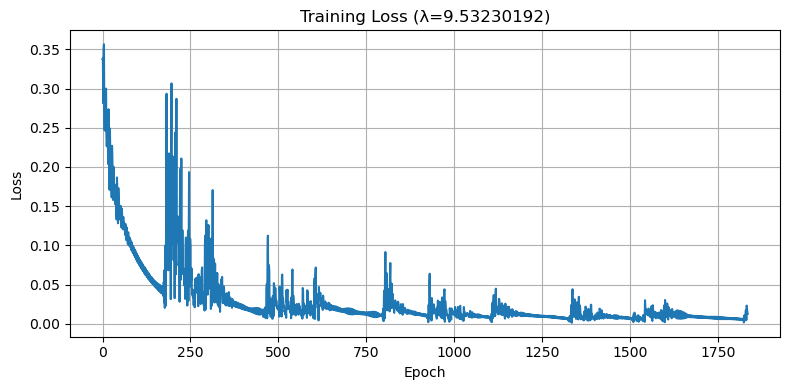

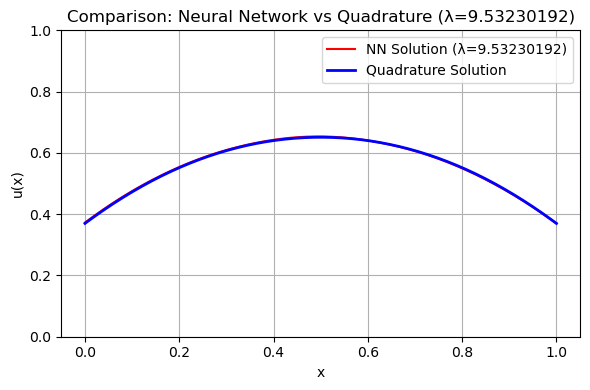


RUNNING MODEL: λ = lambda_19.38
Using sub_min = 0.167800, sup_max = 1.666294 for λ = 19.37997763
Early stopping at epoch 2890 | Best loss: 0.00260666
Training completed after 2891 epochs | Final loss: 0.01570211


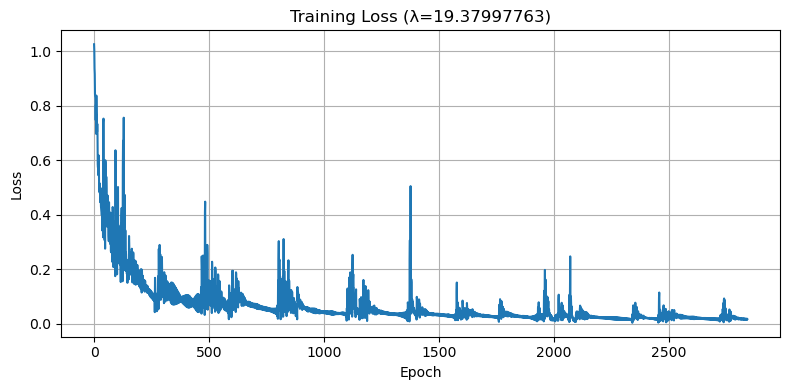

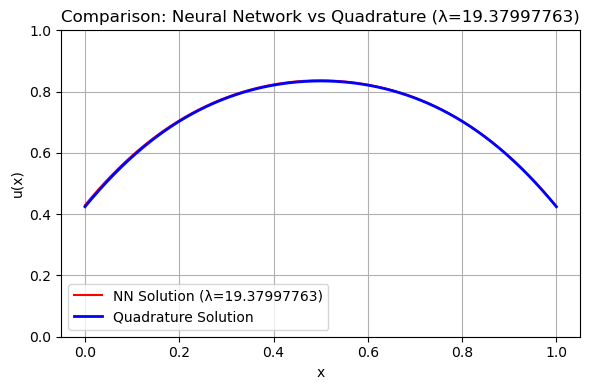


RUNNING MODEL: λ = lambda_35.26
Using sub_min = 0.156112, sup_max = 2.256968 for λ = 35.26398748
Early stopping at epoch 1781 | Best loss: 0.01281109
Training completed after 1782 epochs | Final loss: 0.07707068


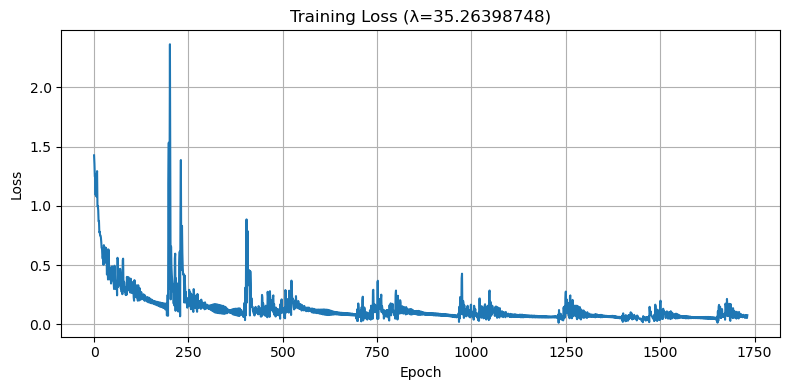

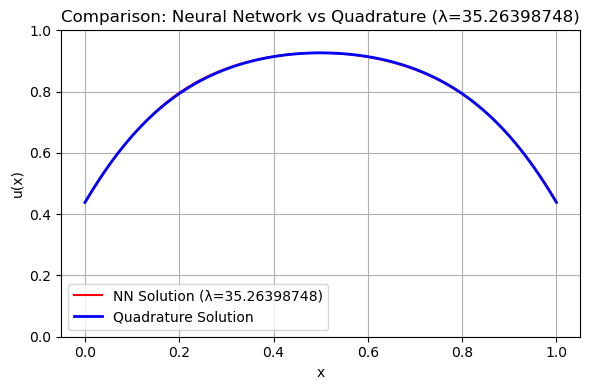

In [17]:
for params in parameter_sets:
    print("\n" + "="*80)
    print(f"RUNNING MODEL: λ = {params['name']}")
    print("="*80)
    
    # Extract parameters
    lambd = params['lambd']
    rho = params['rho']
    u0 = params['u0']

    sub_min, sup_max = compute_subsolution(lambd) # Compute sub and super solution bounds

    print(f"Using sub_min = {sub_min:.6f}, sup_max = {sup_max:.6f} for λ = {lambd}")

    net = Net(sub_min, sup_max).to(device)      # Pass bounds to the network
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    output, losses = train_model(net, optimizer, n_epochs=5000)

    # Plotting training loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.title(f"Training Loss (λ={lambd})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    x_test = np.linspace(0, 1, 500)
    sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), dense_output=True, rtol=1e-9, atol=1e-12)
    x1 = np.linspace(0, 0.5, 100)
    u1 = sol1.sol(x1)
    x2 = 1 - x1
    u2 = u1[:, ::-1]

    x_quad = np.concatenate([x1, x2[::-1]])
    u_quad = np.concatenate([u1.flatten(), u2.flatten()])

    plt.figure(figsize=(6, 4))
    plt.plot(x_test, output, label=f"NN Solution (λ={lambd})", color="red")
    plt.plot(x_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"Comparison: Neural Network vs Quadrature (λ={lambd})")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Note
The Network converged so closely to the actual solution that the NN Solution line (red) and the Numerical Solution line (blue) are stacked on top of each other.

## 5 Results

This section presents the outcomes of applying our bounded PINN framework with CosActivation functions to the nonlinear steady-state reaction-diffusion problem. The results focus on convergence stability, accuracy, and comparisons with high-precision quadrature solutions.

### 5.1 Network Convergence and Stability

- All tested architectures using CosActivation with sigmoid output scaling converged successfully, highlighting the stabilizing effect of bounding the network output using **sub- and super-solutions**.  
- Average errors and training times for different architectures are summarized in Table 4.3.

**Key Observations:**

- Bounding the network with **sub- and super-solutions** ensures all architectures produce physically admissible outputs.  
- Shallower networks converge faster but may have slightly higher error.  
- Medium-depth networks achieve the lowest average error (~0.0006–0.0007) while maintaining moderate training time.  
- Deepest and widest networks do not necessarily improve accuracy, indicating diminishing returns with excessive depth.

### 5.2 Activation Function Performance

- The custom CosActivation function guarantees convergence across all $\lambda$ regimes, outperforming standard activations like Tanh, Sigmoid, ReLU, SiLU, GELU, and Softplus.  
- Smooth, periodic activations are crucial for approximating higher-order derivatives, which directly improves the enforcement of PDE residuals via automatic differentiation.  
- **This confirms that activation choice, combined with output bounding, is critical for stability in stiff nonlinear problems.**

### 5.3 Comparison with Quadrature Solutions

- PINN solutions closely match high-precision quadrature solutions across all tested parameter sets.  
- Visual comparisons show that the network respects the analytically derived bounds and accurately captures the solution profile for both low and high $\lambda$ values.  
- Training losses demonstrate consistent convergence without divergence or instability, validating the bounded PINN framework.

### 5.4 Summary of Findings

- **Bounded output + CosActivation:** Ensures physically valid and stable convergence for all architectures.  
- **Architectural effects:** Moderate-depth networks provide the best trade-off between accuracy and training time.  
- **Validation:** The PINN reliably reproduces the reference quadrature solutions, highlighting the benefits of combining physics-based constraints with smooth, periodic activation functions.  
- **Stiff problem handling:** This framework improves robustness for nonlinear and stiff BVPs, addressing a common challenge in standard PINNs.



## 6 Future Work

The demonstrated success of analytically deriving bounds and incorporating them into the network output layer opens several promising directions for advancing Physics-Informed Neural Networks.

I am currently pursuing a Master of Science in Computer Science, where I am developing a bounded PINN architecture to solve a restricted Navier–Stokes problem aimed at predicting lift values across various wing foil geometries.

#### Other Future Directions

- Parameter conditioning: Extend the network to train jointly on spatial coordinates ($x$) and parameter values ($\lambda$), enabling direct bifurcation analysis.

- Complex boundary conditions: Apply the framework to more complex and stiff boundary conditions involving additional parameters, moving beyond the simplified case studied here.

- Time-dependent systems: Investigate the performance of sub- and super-solution bounds in time-dependent PDEs (e.g., Navier–Stokes), assessing how these constraints influence temporal stability and training efficiency.

## 7 References

1. This proves the existence of a solution within sub-super solutions
- C. V. Pao. Nonlinear parabolic and elliptic equations. Plenum Press, New York, 1992.

2. These two prove the results used in the first two eigenvalue problems
- Robert Stephen Cantrell and Chris Cosner. Spatial Ecology via Reaction-Diffusion Equations. Mathematical and Computational Biology. Wiley, Chichester, 2003.
- Stephen Robinson and M. A. Rivas. Eigen Curves for linear elliptic equations. To appear in ESAIM Control Optim. Calc. Var., 2019.

3. This proves the construction of sub super solutions
- Jerome Goddard II, Quinn Morris, Stephen Robinson, and R. Shivaji. An exact bifurcation diagram for a reaction diffusion equation arising in population dynamics. Boundary
- Value Problems, 170:1–17, 2018.